In [2]:
import numpy as np
import jax.numpy as jnp
import jax
import bayes3d as b
import time
from PIL import Image
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import cv2
import trimesh
import os
import glob
import bayes3d.neural
import pickle
# Can be helpful for debugging:
# jax.config.update('jax_enable_checks', True) 
from bayes3d.neural.segmentation import carvekit_get_foreground_mask
import genjax

In [3]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7016/static/


In [4]:
importance_jit = jax.jit(b.model.importance)
key = jax.random.PRNGKey(10)

In [5]:
paths = glob.glob(
    "panda_scans_v6/*.pkl"
)
all_data = pickle.load(open(paths[0], "rb"))
IDX = 0
data = all_data[IDX]

dict_keys(['rgbPixels', 'depthPixels', 'segmentationMaskBuffer', 'camera_pose', 'camera_matrix'])


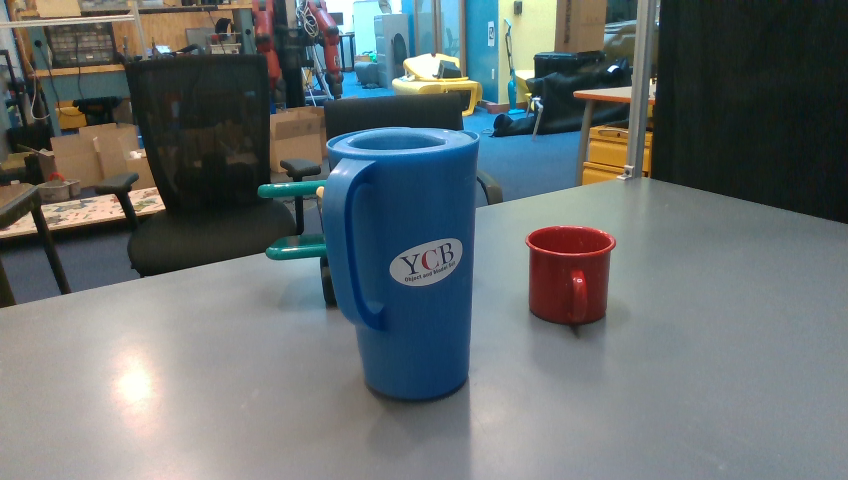

In [6]:
print(data["camera_image"].keys())
K = data["camera_image"]['camera_matrix'][0]
rgb = data["camera_image"]['rgbPixels']
depth = data["camera_image"]['depthPixels']
camera_pose = data["camera_image"]['camera_pose']
camera_pose = b.t3d.pybullet_pose_to_transform(camera_pose)
fx, fy, cx, cy = K[0,0],K[1,1],K[0,2],K[1,2]
h,w = depth.shape
near = 0.001
rgbd_original = b.RGBD(rgb, depth, camera_pose, b.Intrinsics(h,w,fx,fy,cx,cy,0.001,10000.0))
b.get_rgb_image(rgbd_original.rgb)

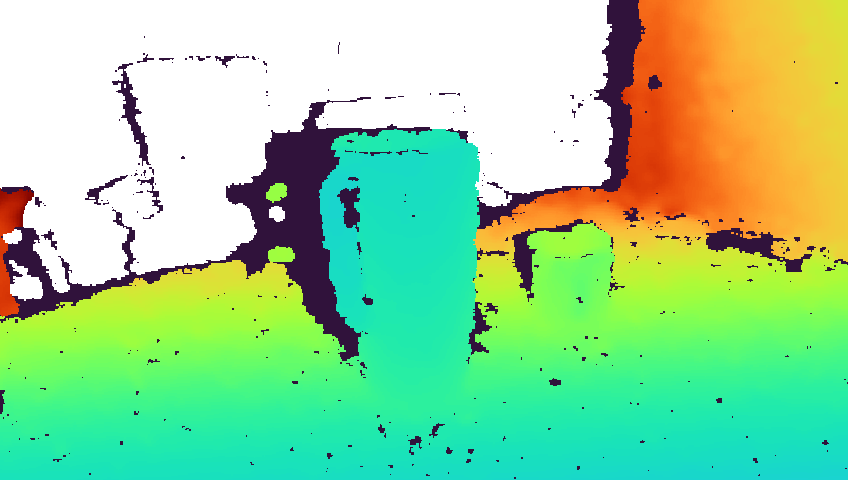

In [7]:
b.get_depth_image(rgbd_original.depth,max=1.5)

In [8]:
scaling_factor = 0.2
rgbd_scaled_down = b.RGBD.scale_rgbd(rgbd_original, scaling_factor)

In [9]:
table_pose, plane_dims = b.utils.infer_table_plane(
    b.unproject_depth(rgbd_scaled_down.depth, rgbd_scaled_down.intrinsics),
    jnp.eye(4), rgbd_scaled_down.intrinsics, 
    ransac_threshold=0.001, inlier_threshold=0.001, segmentation_threshold=0.1
)

In [10]:
b.clear()
b.show_cloud("1", b.unproject_depth(rgbd_scaled_down.depth, rgbd_scaled_down.intrinsics).reshape(-1,3))
b.show_pose("table", table_pose)

In [11]:
b.setup_renderer(rgbd_scaled_down.intrinsics)
b.RENDERER.add_mesh_from_file("toy_plane.ply")
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(13+1).rjust(6, '0') + ".ply")
b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(10+1).rjust(6, '0') + ".ply")
b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)
b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/1000000000.0)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (192, 96, 1024)
Centering mesh with translation [0.   0.   0.09]


In [13]:
width = 0.03
ang = jnp.pi
num_position_grids = 51
num_angle_grids = 51
contact_param_deltas = b.utils.make_translation_grid_enumeration_3d(
    -width, -width, -ang,
    width, width, ang,
    num_position_grids,num_position_grids,num_angle_grids
)

grid_params = [
    (0.5, jnp.pi, (15,15,15)), (0.2, jnp.pi, (15,15,15)), (0.1, jnp.pi, (15,15,15)),
    (0.05, jnp.pi/3, (15,15,15)),
    (0.02, jnp.pi, (9,9,51))
    , (0.01, jnp.pi/5, (15,15,15)),
      (0.01, 0.0, (31,31,1)),(0.05, 0.0, (31,31,1))
]
contact_param_gridding_schedule = [
    b.utils.make_translation_grid_enumeration_3d(
        -x, -x, -ang,
        x, x, ang,
        *nums
    )
    for (x,ang,nums) in grid_params
]

In [14]:
OBJECT_NUMBER = 1
address = f"contact_params_{OBJECT_NUMBER}"
enumerators = b.make_enumerator([address])

In [15]:
contact_param_deltas = contact_param_gridding_schedule[0]
print(contact_param_deltas.shape)

(3375, 3)


In [71]:
obs_img = b.unproject_depth_jit(rgbd_scaled_down.depth, rgbd_scaled_down.intrinsics)
weight, trace = importance_jit(key, genjax.choice_map({
    "parent_0": -1,
    "parent_1": 0,
    "id_0": jnp.int32(3),
    "camera_pose": jnp.eye(4),
    "root_pose_0": table_pose,
    "face_parent_1": 2,
    "face_child_1": 3,
    "image": obs_img,
    "variance": 0.02,
    "outlier_prob": 0.0001,
    "contact_params_1": jnp.array([0.0, 0.0, 0.0])
}), (
    jnp.arange(1),
    jnp.arange(22),
    jnp.array([-jnp.ones(3)*100.0, jnp.ones(3)*100.0]),
    jnp.array([jnp.array([-12.0, -12.0, -22*jnp.pi]), jnp.array([12.0, 12.0, 22*jnp.pi])]),
    b.RENDERER.model_box_dims)
)
b.viz_trace_meshcat(trace)
print(trace.get_score())

-44.589058


In [78]:
OBJECT_NUMBER = 1
address = f"contact_params_{OBJECT_NUMBER}"
enumerators = b.make_enumerator([address])


def c2f_(potential_trace, number, contact_param_gridding_schedule):
    updater = jax.vmap(lambda trace, v: trace.update(
        key,
        genjax.choice_map({
            f"contact_params_{number}": v
        }),
        b.make_unknown_change_argdiffs(trace)
    )[2].get_score(), in_axes=(None, 0))


    cp = potential_trace[address]
    for cp_grid in contact_param_gridding_schedule:
        cps = cp + cp_grid
        scores = updater(potential_trace, cps)
        cp = cps[scores.argmax()]
    potential_trace = enumerators[0](potential_trace, key, cp)
    return potential_trace, scores.argmax()
c2f = jax.jit(c2f_)

In [83]:
key = jax.random.split(key,2)[0]
low, high = jnp.array([-0.4, -0.4, -jnp.pi]), jnp.array([0.4, 0.4, jnp.pi])
potential_trace = b.add_object_jit(trace, key, 2, 0, 2,3)
potential_trace = b.update_address(potential_trace, key, address, jax.random.uniform(key, shape=(3,),minval=low, maxval=high))
b.viz_trace_meshcat(potential_trace)

In [86]:
%%time
key = jax.random.split(key,2)[0]
potential_trace = c2f(potential_trace, 1, contact_param_gridding_schedule)[0]
print(potential_trace["contact_params_1"])
b.viz_trace_meshcat(potential_trace)

[ -2.4379857  -3.1463642 -44.70342  ]
CPU times: user 93.2 ms, sys: 16.9 ms, total: 110 ms
Wall time: 103 ms


: 

Array([-0.700652  , -0.01520425,  0.3865639 ], dtype=float32)